Background distribution: uniform, 50k events   
signal distribution: normal, centered on 60th bin, sdt 5 bin, 500 events

ToDo
- [x] generate data $o_i$ and $e_i$
- [ ] $\chi^2$

In [522]:
import numpy as np
import matplotlib.pyplot as plt

In [523]:
generator = np.random.default_rng(42)

In [524]:
n_bg = 50_000
n_signals = 500
n_bins = 100
bg_signals = generator.uniform(0, 100, n_bg)
real_signals = generator.normal(60, 5, n_signals)
signals = np.concatenate([bg_signals, real_signals])

In [525]:
# observed
o_i, o_edges = np.histogram(signals, bins=n_bins, range=(0, 100))
e_i = np.array([len(signals) / n_bins] * n_bins)

In [526]:
delta_i = (o_i - e_i) / np.sqrt(e_i)

Text(0, 0.5, '$\\Delta_i$')

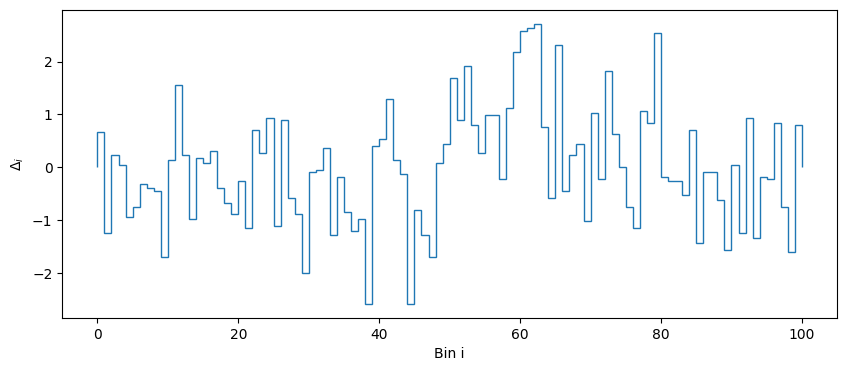

In [527]:
plt.figure(figsize=(10, 4))
plt.stairs(delta_i, o_edges, label="Data")
plt.xlabel("Bin i")
plt.ylabel(r"$\Delta_i$")

In [528]:
chi2 = np.sum(delta_i ** 2)
chi2

121.90099009900992

In [529]:
# only nearest neighbours, i.e. matrix with 0s on the diagonal and 1s on the one upper and one lower diagonal
w_ij = np.zeros((n_bins, n_bins))
for i in range(n_bins):
    if i > 0:
        w_ij[i, i - 1] = 1
    if i < n_bins - 1:
        w_ij[i, i + 1] = 1
print(w_ij)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


Hamiltonian:   
$$ H = -\sum_{i=1}^N \frac{|\Delta_i| \Delta_i}{2} \frac{s_i}{2} - \frac{\lambda}{2} \sum_{ij} \omega_{ij} \frac{(\Delta_i + \Delta_j)^2}{4} \frac{1+s_i s_j}{2} $$

In [ ]:
def Hamiltonian(s_i, delta_i, w_ij, lamb):
    r"""
    Computes the Ising Hamiltonian:

    $$ H = -\sum_{i=1}^N \frac{|\Delta_i| \Delta_i}{2} \frac{s_i}{2} 
         - \frac{\lambda}{2} \sum_{ij} \omega_{ij} \frac{(\Delta_i + \Delta_j)^2}{4} \frac{1+s_i s_j}{2} $$

    Parameters:
    - s_i: Array of spin values (+1 or -1)
    - delta_i: Array of deviations Δ_i
    - w_ij: Interaction matrix ω_ij
    - lamb: Coupling parameter λ

    Returns:
    - Hamiltonian value
    """
    a = - np.sum(np.abs(delta_i) * delta_i * s_i) / 4  # First term

    dd = np.add.outer(delta_i, delta_i)**2 / 4.0  # Efficient pairwise Δ sum
    ss = (1 + np.outer(s_i, s_i)) / 2.0  # Interaction factor
    
    b = - (lamb / 2.0) * np.sum(w_ij * dd * ss)  # Second term
    
    return a + b

In [531]:
# s_i either -1 or 1
# random initialisation
s_i = generator.choice([-1, 1], n_bins)

In [532]:
Hamiltonian(s_i, delta_i, w_ij, 1)

-31.394554455445547

QUBO formulation
$
\begin{align}
H &= C_A + C_B + \sum_i Q_i x_i + \sum_{ij} Q_{ij} x_i x_j \\
Q_i &= -\frac{|\Delta_i| \Delta_i}{2} + \lambda \sum_j w_{ij} \frac{(\Delta_i + \Delta_j)^2}{4} \\
Q_{ij} &= \lambda \omega_{ij} \frac{(\Delta_i + \Delta_j)^2}{4}\\
C_A &= \sum_i \frac{|\Delta_i| \Delta_i}{4} \\
C_B &= - \frac{\lambda}{2} \sum_{ij} w_{ij} \frac{(\Delta_i + \Delta_j)^2}{4}
\end{align}
$

In [593]:
def calc_Qi(delta_i, w_ij, lamb):
    dd = (delta_i[:, np.newaxis] + delta_i[np.newaxis, :])**2 / 4.0
    return - np.abs(delta_i) * delta_i / 2.0 + lamb * np.sum(w_ij * dd, axis=1)

def calc_Qij(delta_i, w_ij, lamb):
    dd = (delta_i[:, np.newaxis] + delta_i[np.newaxis, :])**2 / 4.0
    return - lamb * w_ij * dd

def calc_CA(delta_i, w_ij, lamb):
    dd = np.abs(delta_i) * delta_i / 4
    return np.sum(dd)

def calc_CB(delta_i, w_ij, lamb):
    dd = (delta_i[:, np.newaxis] + delta_i[np.newaxis, :])**2 / 4.0
    return - (lamb / 2.0) * np.sum(w_ij * dd)

def calc_H_QUBO(s_i, delta_i, w_ij, lamb):
    x_i = (s_i + 1) / 2
    a = np.sum(calc_Qi(delta_i, w_ij, lamb) * x_i)
    b = np.sum(calc_Qij(delta_i, w_ij, lamb) * np.outer(x_i, x_i))
    c = calc_CA(delta_i, w_ij, lamb)
    d = calc_CB(delta_i, w_ij, lamb)
    print(f"{a=}, {b=}, {c=}, {d=}")
    return a + b + c + d

In [594]:
calc_H_QUBO(s_i, delta_i, w_ij, 1)

a=54.51188118811882, b=-9.277227722772277, c=2.852475247524753, d=-79.48168316831683


-31.394554455445544

In [595]:
Hamiltonian(s_i, delta_i, w_ij, 1)

-31.394554455445547

In [596]:
calc_Qij(delta_i, w_ij, 1)

array([[-0.        , -0.08366337, -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.08366337, -0.        , -0.26188119, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.26188119, -0.        , ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -1.39059406, -0.        ],
       [-0.        , -0.        , -0.        , ..., -1.39059406,
        -0.        , -0.16039604],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.16039604, -0.        ]])

In [600]:
calc_Qi(delta_i, w_ij, 100)

array([   8.14356436,   35.33069307,   27.94554455,   21.58316832,
         91.72376238,  100.28613861,   41.23663366,   30.62475248,
        132.02970297,  176.13267327,  132.11980198,  149.48019802,
         93.49009901,   30.82574257,   17.80594059,    5.78811881,
          4.15940594,   28.79306931,   89.38118812,   94.5049505 ,
         84.19405941,   56.31287129,   28.65742574,   60.01386139,
         36.44455446,    2.64851485,    3.26732673,   56.5039604 ,
        263.46534653,  320.51980198,  109.80594059,    2.87227723,
         24.19405941,   76.57524752,   80.11485149,  131.2980198 ,
        224.33564356,  436.17227723,  439.02376238,  140.61287129,
        104.90693069,  133.07821782,   50.68415842,  184.21683168,
        473.47920792,  395.61782178,  332.41683168,  287.81584158,
         71.28316832,  121.08910891,  279.16435644,  362.62376238,
        378.86237624,  212.4019802 ,   67.29108911,  134.17425743,
        109.66930693,   34.13366337,  290.27227723,  835.49405